In [1]:
# Data manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Statistical modeling
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Preprocessing
from sklearn.preprocessing import StandardScaler

# Statistical tests
from scipy.stats import skew, kurtosis, shapiro

# Coordinate transformation and distance calculation
from pyproj import Transformer
from scipy.spatial.distance import cdist
import math

from statsmodels.stats.diagnostic import het_breuschpagan

In [2]:
df = pd.read_excel("company-university-NJ.xlsx")

print("Initial data overview:")
df.info()

print("\nMissing values:")
print(df.isnull().sum())

Initial data overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8037 entries, 0 to 8036
Data columns (total 12 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   number_of_patents                          8037 non-null   int64  
 1   city                                       8037 non-null   object 
 2   county                                     8037 non-null   object 
 3   national_industry_category(GB standard)    8037 non-null   object 
 4   date                                       8037 non-null   object 
 5   insured_population                         8037 non-null   int64  
 6   x_utm                                      8037 non-null   float64
 7   y_utm                                      8037 non-null   float64
 8   nearest_university_distance_m              8037 non-null   float64
 9   double_world_class                         8037 non-null   int64  
 10  U

In [3]:
# Convert establishment date to datetime format
df['date'] = pd.to_datetime(df['date'], errors='coerce')

# Calculate firm age in years
today = pd.Timestamp.today()
df['enterprise_age'] = (today - df['date']).dt.days / 365.25

# Display age range
print(f"Firm age computed: range {df['enterprise_age'].min():.1f} ~ {df['enterprise_age'].max():.1f} years")

Firm age computed: range 2.4 ~ 45.7 years


In [4]:
# Define the order of industry categories with 'Manufacturing' as the baseline (first)
industry_order = [
    'Manufacturing',  # Baseline category
    'Agriculture and Related Activities',
    'Other Services',
    'R&D and IT Services',
    'Trade, Construction, and Business Services',
    'Utilities and Infrastructure'
]

# Convert the industry column to a categorical type with specified order
df['national_industry_category(GB standard)'] = pd.Categorical(
    df['national_industry_category(GB standard)'],
    categories=industry_order,
    ordered=True
)

# Create dummy variables, dropping the first category ('Manufacturing') as the baseline
df = pd.get_dummies(df, columns=['national_industry_category(GB standard)'], drop_first=True)

# Rename dummy variable columns for clarity
df.rename(columns={
    'national_industry_category(GB standard)_Agriculture and Related Activities': 'industry_agriculture',
    'national_industry_category(GB standard)_Other Services': 'industry_other_services',
    'national_industry_category(GB standard)_R&D and IT Services': 'industry_rnd_it',
    'national_industry_category(GB standard)_Trade, Construction, and Business Services': 'industry_trade_construction_business',
    'national_industry_category(GB standard)_Utilities and Infrastructure': 'industry_utilities'
}, inplace=True)

# Define the list of dummy variable columns (excluding the baseline)
industry_cols = [
    'industry_agriculture',
    'industry_other_services',
    'industry_rnd_it',
    'industry_trade_construction_business',
    'industry_utilities'
]

print(f"Industry dummy variables created (baseline = 'Manufacturing'): {industry_cols}")

Industry dummy variables created (baseline = 'Manufacturing'): ['industry_agriculture', 'industry_other_services', 'industry_rnd_it', 'industry_trade_construction_business', 'industry_utilities']



Descriptive statistics of numerical variables:
       nearest_university_distance_m  \
count                    8037.000000   
mean                     3851.655691   
std                      4044.717127   
min                         0.000000   
25%                      1281.494287   
50%                      2358.077605   
75%                      5046.520777   
max                     37080.322224   

       distance_to_nearest_bachelor_university_m  insured_population  \
count                                8037.000000         8037.000000   
mean                                 4600.946552           73.930571   
std                                  4869.451553          279.981626   
min                                    20.146359            0.000000   
25%                                  1545.482300            6.000000   
50%                                  2560.068910           18.000000   
75%                                  6191.614359           52.000000   
max            

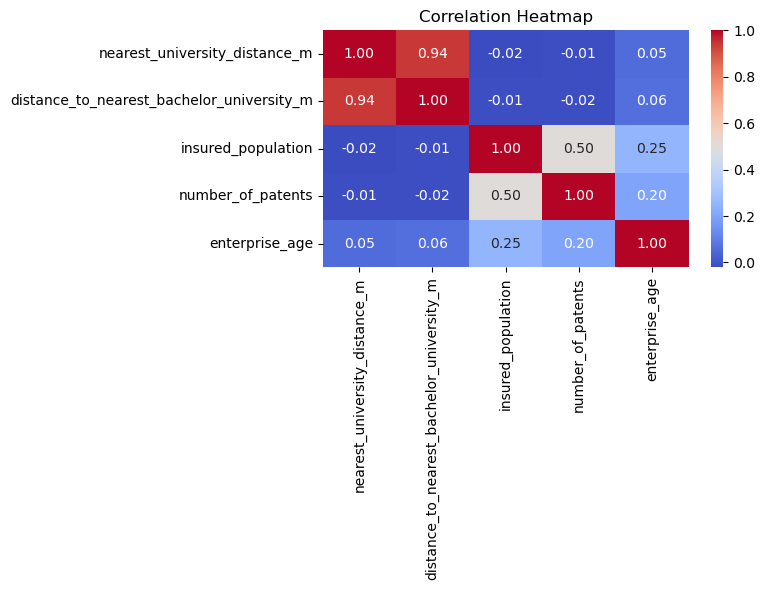

In [6]:
# Descriptive statistics and correlation
num_vars = [
    'nearest_university_distance_m', 'distance_to_nearest_bachelor_university_m', 'insured_population',
    'number_of_patents', 'enterprise_age'
]

print("\nDescriptive statistics of numerical variables:")
print(df[num_vars].describe())

# Correlation matrix
corr_matrix = df[num_vars].corr()
print("\nCorrelation matrix:")
print(corr_matrix)

plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.tight_layout()
plt.show()

corr_matrix.to_csv("correlation_matrix.csv")

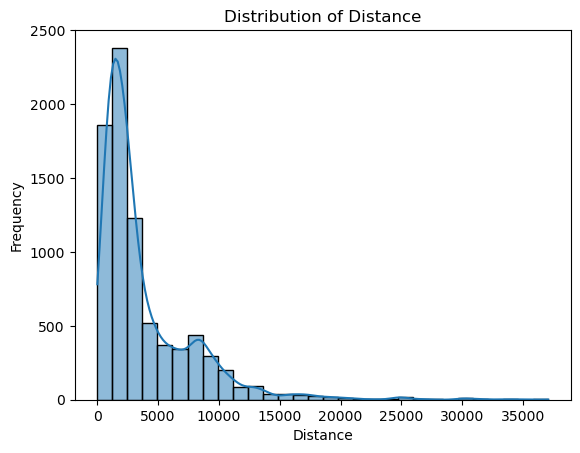


Skewness of `distance`: 2.57
Kurtosis of `distance`: 10.00
Shapiro-Wilk test p-value: 0.0000


D:\anaconda0804\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 8037.
  res = hypotest_fun_out(*samples, **kwds)


In [7]:
# Target variable distribution
plt.figure()
sns.histplot(df['nearest_university_distance_m'], kde=True, bins=30)
plt.title("Distribution of Distance")
plt.xlabel("Distance")
plt.ylabel("Frequency")
plt.show()

dist_skew = skew(df['nearest_university_distance_m'])
dist_kurt = kurtosis(df['nearest_university_distance_m'])
print(f"\nSkewness of `distance`: {dist_skew:.2f}")
print(f"Kurtosis of `distance`: {dist_kurt:.2f}")

stat, p_value = shapiro(df['nearest_university_distance_m'])
print(f"Shapiro-Wilk test p-value: {p_value:.4f}")
if p_value < 0.05:
    print("Warning: `distance` deviates from normality. Consider log-transform.")
    df['log_nearest_university_distance_m'] = np.log1p(df['nearest_university_distance_m'])
    y1_var = "log_nearest_university_distance_m"
else:
    y1_var = "nearest_university_distance_m"

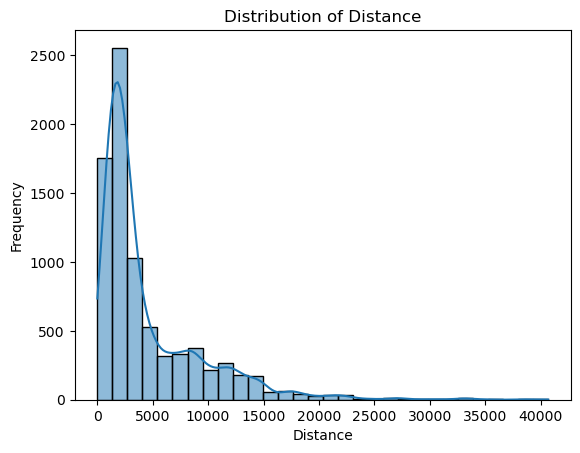


Skewness of `distance`: 2.25
Kurtosis of `distance`: 6.90
Shapiro-Wilk test p-value: 0.0000


D:\anaconda0804\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 8037.
  res = hypotest_fun_out(*samples, **kwds)


In [8]:
# Target variable distribution
plt.figure()
sns.histplot(df['distance_to_nearest_bachelor_university_m'], kde=True, bins=30)
plt.title("Distribution of Distance")
plt.xlabel("Distance")
plt.ylabel("Frequency")
plt.show()

dist_skew = skew(df['distance_to_nearest_bachelor_university_m'])
dist_kurt = kurtosis(df['distance_to_nearest_bachelor_university_m'])
print(f"\nSkewness of `distance`: {dist_skew:.2f}")
print(f"Kurtosis of `distance`: {dist_kurt:.2f}")

stat, p_value = shapiro(df['distance_to_nearest_bachelor_university_m'])
print(f"Shapiro-Wilk test p-value: {p_value:.4f}")
if p_value < 0.05:
    print("Warning: `distance` deviates from normality. Consider log-transform.")
    df['log_distance_to_nearest_bachelor_university_m'] = np.log1p(df['distance_to_nearest_bachelor_university_m'])
    y2_var = "log_distance_to_nearest_bachelor_university_m"
else:
    y2_var = "distance_to_nearest_bachelor_university_m"

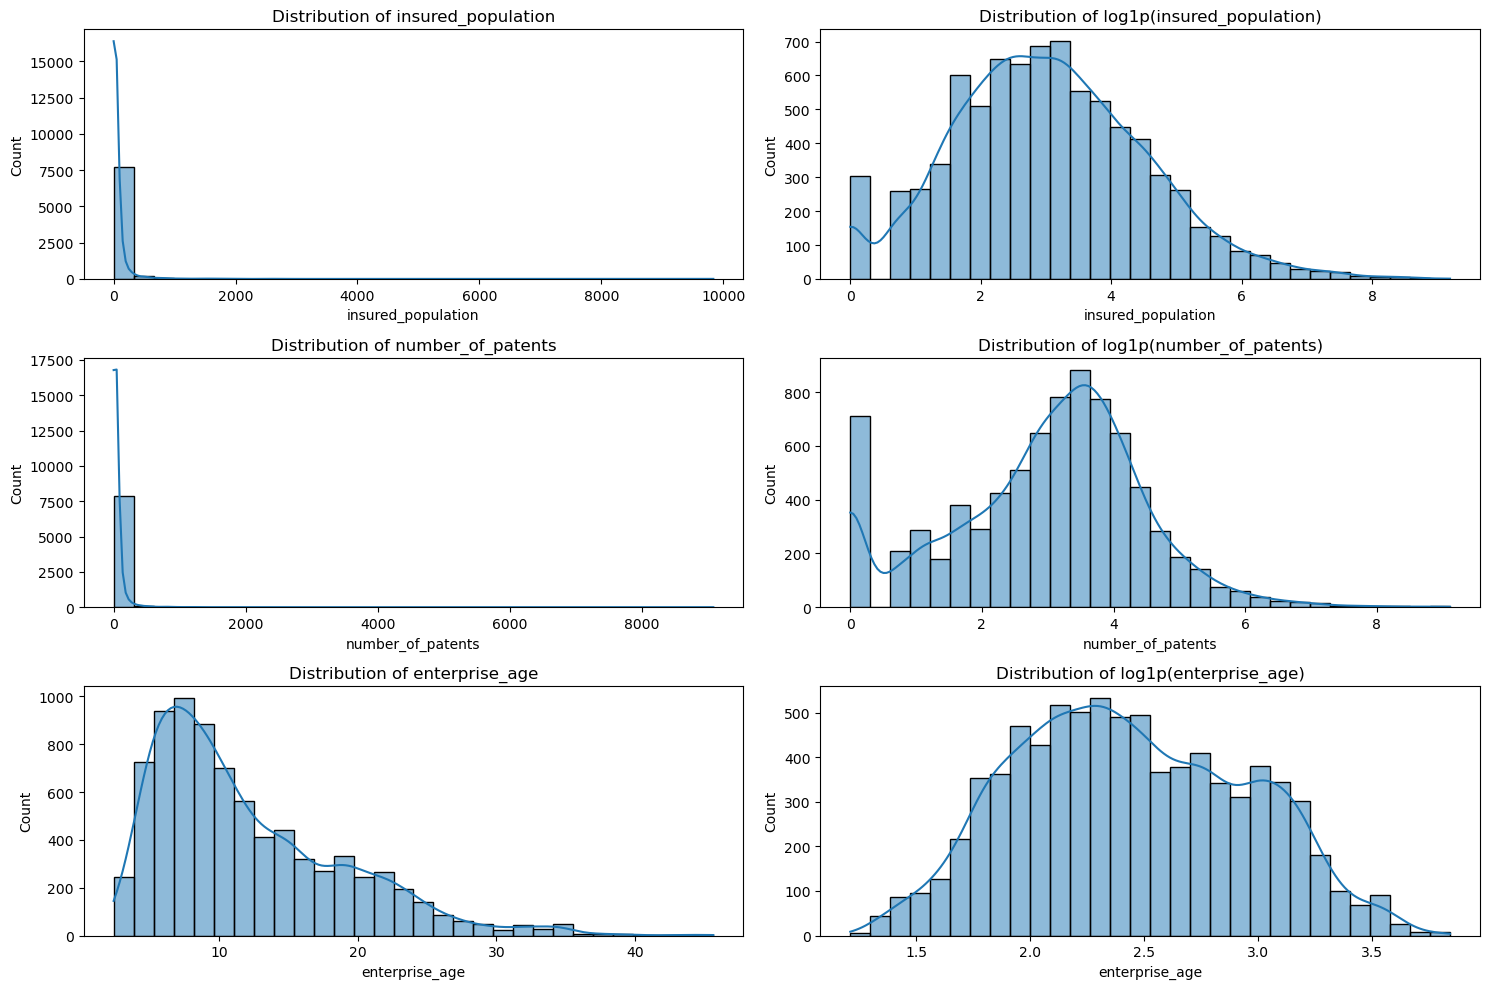

In [9]:
# Define variable list
variables = ['insured_population', 'number_of_patents', 'enterprise_age']

# Plot distributions
plt.figure(figsize=(15, 10))

for i, var in enumerate(variables):
    # Original distribution
    plt.subplot(3, 2, 2*i+1)
    sns.histplot(df[var].dropna(), bins=30, kde=True)
    plt.title(f"Distribution of {var}")

    # log1p-transformed distribution
    plt.subplot(3, 2, 2*i+2)
    sns.histplot(np.log1p(df[var].dropna()), bins=30, kde=True)
    plt.title(f"Distribution of log1p({var})")

plt.tight_layout()
plt.show()

In [10]:
# Apply log(1 + x) transformation to reduce skewness and handle zeros safely
df['log_number_of_patents'] = np.log1p(df['number_of_patents'])
df['log_insured_population'] = np.log1p(df['insured_population'])
df['log_enterprise_age'] = np.log1p(df['enterprise_age'])

In [11]:
# Standardize numerical independent variables
std_vars = [
    'log_insured_population', 'log_number_of_patents', 'log_enterprise_age'
]
scaler = StandardScaler()
df[std_vars] = scaler.fit_transform(df[std_vars])

In [12]:
# Define y and prepare X for VIF

# Use log-transformed distance as the dependent variable
df['log_nearest_university_distance_m'] = np.log1p(df['nearest_university_distance_m'])  # log(1 + x) avoids log(0)
y1 = df['nearest_university_distance_m']  #  this is the new target variable
# Use log-transformed distance as the dependent variable
df['log_distance_to_nearest_bachelor_university_m'] = np.log1p(df['distance_to_nearest_bachelor_university_m'])  # log(1 + x) avoids log(0)
y2 = df['distance_to_nearest_bachelor_university_m']  #  this is the new target variable

# Combine standardized numeric variables and industry dummies
X_vars = std_vars + industry_cols + ['double_world_class']
X = df[X_vars]

In [13]:
X

,log_insured_population,log_number_of_patents,log_enterprise_age,industry_agriculture,industry_other_services,industry_rnd_it,industry_trade_construction_business,industry_utilities,double_world_class
0,2.635699,0.688797,0.613371,False,False,False,True,False,1
1,2.499295,1.148875,1.308535,False,False,True,False,False,0
2,-0.486846,0.315407,-1.021429,False,False,False,False,False,0
3,1.460070,0.770803,-1.324814,False,False,True,False,False,0
4,1.122193,1.621469,1.177138,False,False,True,False,False,0
...,...,...,...,...,...,...,...,...,...
8032,-0.830931,-1.994913,-1.017471,False,False,True,False,False,0
8033,-1.297826,-1.994913,-0.235393,False,False,True,False,False,0
8034,-0.637153,-1.994913,-1.975747,False,False,True,False,False,0
8035,-1.570942,-1.994913,-1.329436,False,False,True,False,False,0


In [14]:
print("\n X column data types:")
print(X.dtypes)


 X column data types:
log_insured_population                  float64
log_number_of_patents                   float64
log_enterprise_age                      float64
industry_agriculture                       bool
industry_other_services                    bool
industry_rnd_it                            bool
industry_trade_construction_business       bool
industry_utilities                         bool
double_world_class                        int64
dtype: object


In [15]:
# Construct the squared term of log-transformed number of patents
df['log_patent_sq'] = df['log_number_of_patents'] ** 2

In [16]:
X_vars = std_vars + industry_cols + ['double_world_class'] + ['log_patent_sq']
X = df[X_vars]

In [17]:
X = df[X_vars].copy()
X = X.astype(float) 

In [18]:
# VIF calculation
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif_df = pd.DataFrame()
vif_df["feature"] = X.columns
vif_df["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print("\n Variance Inflation Factors (VIF):")
print(vif_df)


 Variance Inflation Factors (VIF):
                                feature       VIF
0                log_insured_population  1.701370
1                 log_number_of_patents  1.751467
2                    log_enterprise_age  1.396942
3                  industry_agriculture  1.001109
4               industry_other_services  1.007167
5                       industry_rnd_it  1.758323
6  industry_trade_construction_business  1.099666
7                    industry_utilities  1.012734
8                    double_world_class  1.370905
9                         log_patent_sq  1.529834


In [20]:
# Combine all independent variables
all_vars = std_vars + industry_cols + ['double_world_class', 'log_patent_sq']

# Define regression formula with city fixed effects
formula1 = 'log_nearest_university_distance_m ~ ' + ' + '.join(all_vars) + ' + C(county , Treatment(reference="JiangNing"))'

# Fit the OLS regression model
model1 = smf.ols(formula=formula1, data=df).fit()
print(model1.summary())

                                    OLS Regression Results                                   
Dep. Variable:     log_nearest_university_distance_m   R-squared:                       0.333
Model:                                           OLS   Adj. R-squared:                  0.332
Method:                                Least Squares   F-statistic:                     200.5
Date:                               Thu, 07 Aug 2025   Prob (F-statistic):               0.00
Time:                                       11:13:28   Log-Likelihood:                -9714.3
No. Observations:                               8037   AIC:                         1.947e+04
Df Residuals:                                   8016   BIC:                         1.962e+04
Df Model:                                         20                                         
Covariance Type:                           nonrobust                                         
                                                            

In [21]:
# Combine all explanatory variables
all_vars = std_vars + industry_cols + ['double_world_class', 'log_patent_sq']

# Define the regression formula
formula2 = 'log_distance_to_nearest_bachelor_university_m ~ ' + ' + '.join(all_vars) + ' + C(county , Treatment(reference="JiangNing"))'

# Fit the OLS regression model
model2 = smf.ols(formula=formula2, data=df).fit()
print(model2.summary())

                                          OLS Regression Results                                         
Dep. Variable:     log_distance_to_nearest_bachelor_university_m   R-squared:                       0.416
Model:                                                       OLS   Adj. R-squared:                  0.414
Method:                                            Least Squares   F-statistic:                     285.3
Date:                                           Thu, 07 Aug 2025   Prob (F-statistic):               0.00
Time:                                                   11:14:26   Log-Likelihood:                -8985.6
No. Observations:                                           8037   AIC:                         1.801e+04
Df Residuals:                                               8016   BIC:                         1.816e+04
Df Model:                                                     20                                         
Covariance Type:                              

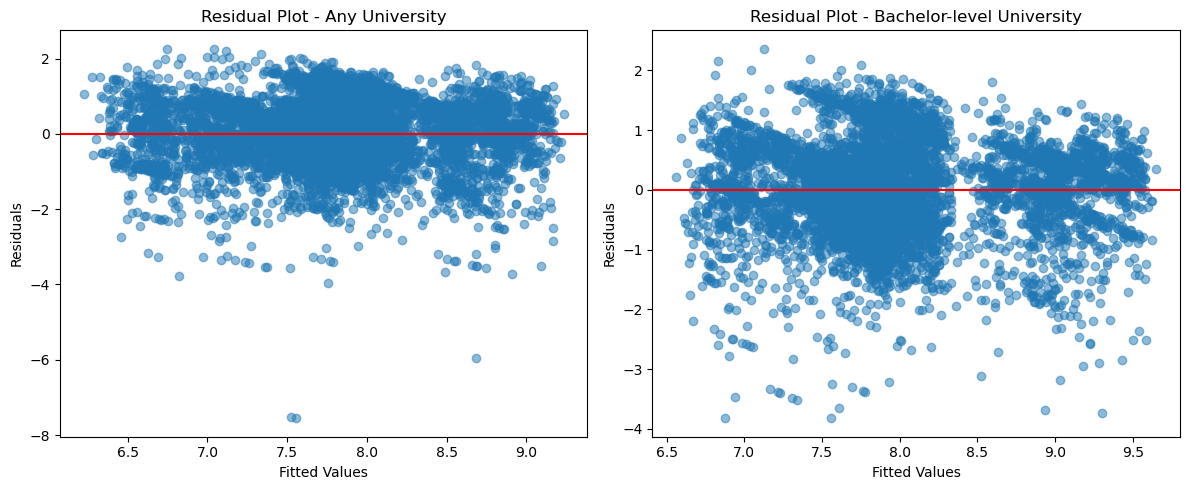

In [22]:
# Create side-by-side residual plots
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Residual plot for distance to any university
axs[0].scatter(model1.fittedvalues, model1.resid, alpha=0.5)
axs[0].axhline(0, color='red')
axs[0].set_title("Residual Plot - Any University")
axs[0].set_xlabel("Fitted Values")
axs[0].set_ylabel("Residuals")

# Residual plot for distance to nearest bachelor-level university
axs[1].scatter(model2.fittedvalues, model2.resid, alpha=0.5)
axs[1].axhline(0, color='red')
axs[1].set_title("Residual Plot - Bachelor-level University")
axs[1].set_xlabel("Fitted Values")
axs[1].set_ylabel("Residuals")

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

In [23]:
# Extract residuals and design matrix from the model
resid = model1.resid
exog = model1.model.exog  # Matrix of explanatory variables

# Perform the Breusch-Pagan test
bp_test = het_breuschpagan(resid, exog)

# Print test results
bp_labels = ['Lagrange Multiplier statistic', 'p-value', 'F-statistic', 'F p-value']
for name, value in zip(bp_labels, bp_test):
    print(f"{name}: {value:.4f}")

Lagrange Multiplier statistic: 118.1969
p-value: 0.0000
F-statistic: 5.9824
F p-value: 0.0000


In [24]:
# Extract residuals and design matrix from the model
resid = model2.resid
exog = model2.model.exog  # Matrix of explanatory variables

# Perform the Breusch-Pagan test
bp_test = het_breuschpagan(resid, exog)

# Print test results
bp_labels = ['Lagrange Multiplier statistic', 'p-value', 'F-statistic', 'F p-value']
for name, value in zip(bp_labels, bp_test):
    print(f"{name}: {value:.4f}")

Lagrange Multiplier statistic: 176.8973
p-value: 0.0000
F-statistic: 9.0203
F p-value: 0.0000


In [25]:
model1_robust = model1.get_robustcov_results(cov_type='HC1')
print(model1_robust.summary())

model2_robust = model2.get_robustcov_results(cov_type='HC1')
print(model2_robust.summary())

                                    OLS Regression Results                                   
Dep. Variable:     log_nearest_university_distance_m   R-squared:                       0.333
Model:                                           OLS   Adj. R-squared:                  0.332
Method:                                Least Squares   F-statistic:                     188.4
Date:                               Thu, 07 Aug 2025   Prob (F-statistic):               0.00
Time:                                       11:14:54   Log-Likelihood:                -9714.3
No. Observations:                               8037   AIC:                         1.947e+04
Df Residuals:                                   8016   BIC:                         1.962e+04
Df Model:                                         20                                         
Covariance Type:                                 HC1                                         
                                                            